<a href="https://colab.research.google.com/github/danbennett239/CI603/blob/main/CI603_Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.ensemble import IsolationForest
from itertools import product

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Dataset Description and Visualisation

#### Dataset Structure and Integrity

In [46]:
# Load the dataset and check its shape, column names, and missing values
df = pd.read_csv('/content/drive/MyDrive/CI603/creditcard.csv')
print(f"Dataset shape: {df.shape}")
print("\nColumn names:")
print(df.columns.tolist())

missing = df.isnull().sum()
print("\nMissing values per column:")
print(missing[missing > 0] if missing.sum() > 0 else "No missing values found.")

Dataset shape: (284807, 31)

Column names:
['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

Missing values per column:
No missing values found.


#### Class Distribution and Imbalance

In [48]:
# Display fraud vs normal class counts and their percentage
class_counts = df['Class'].value_counts()
total = class_counts.sum()
fraud_pct = (class_counts[1] / total) * 100
normal_pct = (class_counts[0] / total) * 100

print("\nClass Distribution:")
print(f"Normal transactions: {class_counts[0]} ({normal_pct:.4f}%)")
print(f"Fraudulent transactions: {class_counts[1]} ({fraud_pct:.4f}%)")


Class Distribution:
Normal transactions: 284315 (99.8273%)
Fraudulent transactions: 492 (0.1727%)


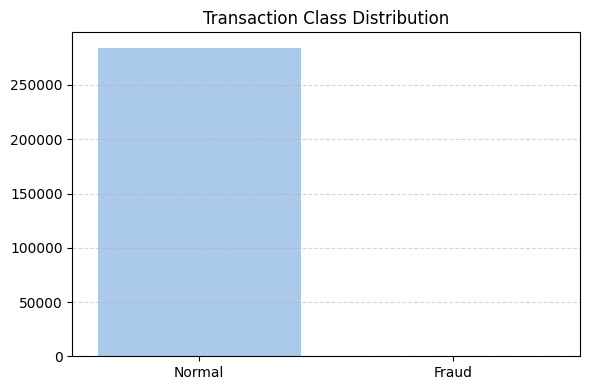

In [41]:
# Bar plot of transaction counts by class
plt.figure(figsize=(6, 4))
sns.barplot(x=['Normal', 'Fraud'], y=class_counts.values, hue=['Normal', 'Fraud'], palette='pastel', legend=False)
plt.title('Transaction Class Distribution')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

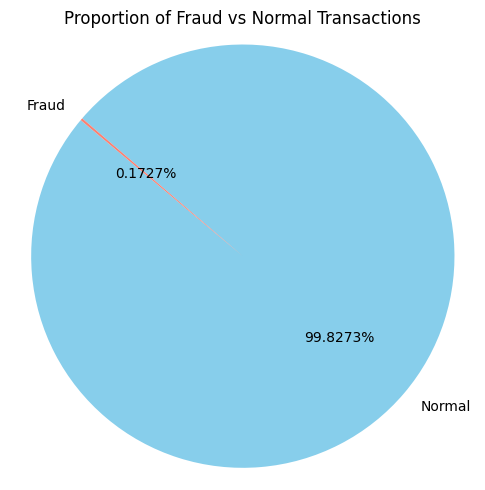

In [40]:
# Pie chart showing class proportions
plt.figure(figsize=(5, 5))
plt.pie(class_counts, labels=['Normal', 'Fraud'], autopct='%1.4f%%', colors=['skyblue', 'salmon'], startangle=140)
plt.title('Proportion of Fraud vs Normal Transactions')
plt.axis('equal')
plt.tight_layout()
plt.show()

#### Summary Statistics for Time, Amount, and PCA Features

In [42]:
# Summary statistics for time and amount
print("\nSummary Statistics for Time and Amount:")
print(df[['Time', 'Amount']].describe())

# Summary statistics for V1–V28 PCA features
print("\nPCA Features Summary (V1–V28):")
print(df[[f'V{i}' for i in range(1, 29)]].describe())


Summary Statistics for Time and Amount:
                Time         Amount
count  284807.000000  284807.000000
mean    94813.859575      88.349619
std     47488.145955     250.120109
min         0.000000       0.000000
25%     54201.500000       5.600000
50%     84692.000000      22.000000
75%    139320.500000      77.165000
max    172792.000000   25691.160000

PCA Features Summary (V1–V28):
                 V1            V2            V3            V4            V5  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15  9.604066e-16   
std    1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00  1.380247e+00   
min   -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00 -1.137433e+02   
25%   -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01 -6.915971e-01   
50%    1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02 -5.433583e-02   
75%    1.315642e+00  8.037239e-01  1.027196e+00  7

#### Correlation Between Features and Class

In [ ]:
# Correlation of Time and scaled Amount with the Class label
df['Amount_scaled'] = StandardScaler().fit_transform(df[['Amount']])
corr = df[['Amount_scaled', 'Time', 'Class']].corr()['Class']
print("\nCorrelation with Class:")
print(corr)

#### Distribution of Time and Amount by Class

In [ ]:
# KDE plots showing distributions of Time and Amount_scaled by class
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.kdeplot(data=df[df['Class'] == 0], x='Amount_scaled', label='Normal', color='skyblue')
sns.kdeplot(data=df[df['Class'] == 1], x='Amount_scaled', label='Fraud', color='salmon')
plt.title('Scaled Amount Distribution by Class')
plt.xlabel('Scaled Amount')
plt.legend()

plt.subplot(1, 2, 2)
sns.kdeplot(data=df[df['Class'] == 0], x='Time', label='Normal', color='skyblue')
sns.kdeplot(data=df[df['Class'] == 1], x='Time', label='Fraud', color='salmon')
plt.title('Time Distribution by Class')
plt.xlabel('Time (seconds)')
plt.legend()

plt.tight_layout()
plt.savefig("intro_amount_time_dist.png")
plt.show()


#### Boxplot of Transaction Amounts by Class

In [ ]:
# Boxplot comparing transaction amounts across classes (log scale)
plt.figure(figsize=(6, 4))
sns.boxplot(x='Class', y='Amount', data=df, palette='pastel', hue='Class', legend=False)
plt.title('Amount Distribution by Class')
plt.xlabel('Class (0=Normal, 1=Fraud)')
plt.ylabel('Amount (Log Scale)')
plt.yscale('log')
plt.savefig("intro_amount_boxplot.png")
plt.show()

#### Temporal Distribution of Fraudulent Transactions

In [ ]:
# Histogram showing when fraud occurs over the dataset's time range
plt.figure(figsize=(10, 4))
fraud_times = df[df['Class'] == 1]['Time']
plt.hist(fraud_times, bins=50, color='salmon', alpha=0.7)
plt.title('Fraud Occurrences Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Number of Fraud Transactions')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.savefig("intro_fraud_time_series.png")
plt.show()

#### PCA Feature Scale Verification

In [49]:
# Check that PCA components are roughly standardised (mean≈0, std≈1)
pca_stats = pd.DataFrame({
    'Mean': df[[f'V{i}' for i in range(1, 29)]].mean(),
    'Std': df[[f'V{i}' for i in range(1, 29)]].std()
})
print("\nPCA Features Scale Verification (Means and Stds):")
print(pca_stats.describe())


PCA Features Scale Verification (Means and Stds):
               Mean        Std
count  2.800000e+01  28.000000
mean   7.627408e-16   0.976391
std    1.541343e-15   0.386740
min   -2.406331e-15   0.330083
25%   -1.812691e-16   0.732318
50%    7.298102e-16   0.936956
75%    1.450115e-15   1.205038
max    4.887456e-15   1.958696


### Feature Selection and Dimensionality Reduction

In [ ]:
scaler = StandardScaler()
df['Amount_scaled'] = scaler.fit_transform(df[['Amount']])
print("Correlation with Class:")
print(df[['Amount_scaled', 'Time', 'Class']].corr()['Class'])

Correlation with Class:
Amount_scaled    0.005632
Time            -0.012323
Class            1.000000
Name: Class, dtype: float64


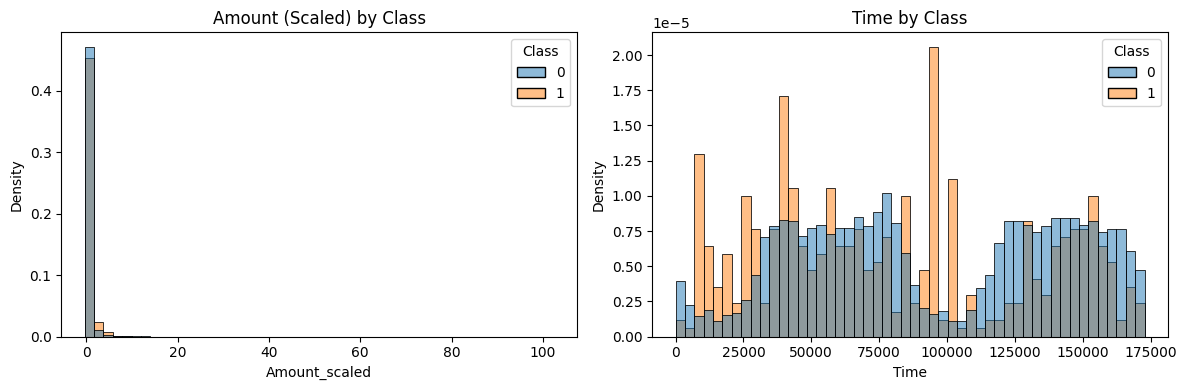

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='Amount_scaled', hue='Class', bins=50, stat='density', common_norm=False)
plt.title('Amount (Scaled) by Class')
plt.subplot(1, 2, 2)
sns.histplot(data=df, x='Time', hue='Class', bins=50, stat='density', common_norm=False)
plt.title('Time by Class')
plt.tight_layout()
plt.show()

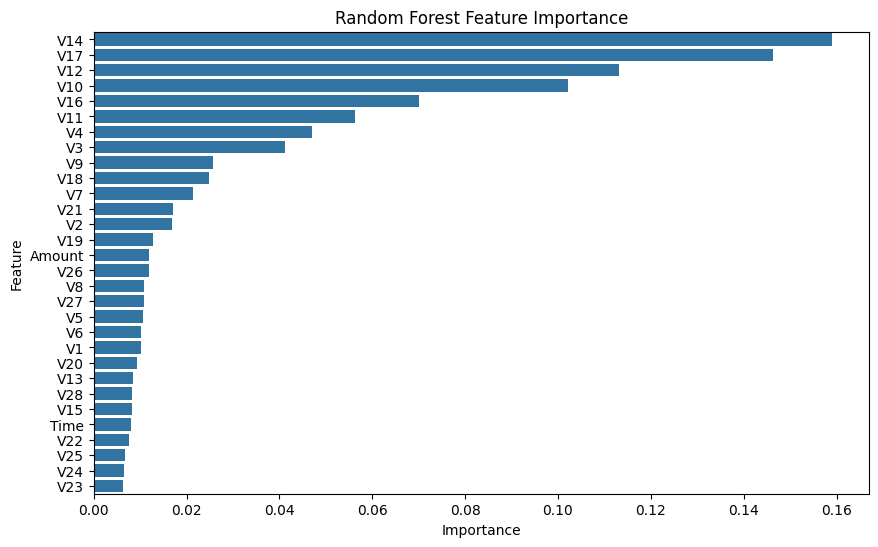

In [ ]:
# Step 2: Random Forest Feature Importance
# Prepare data (exclude 'Class' and 'Amount_scaled' for now)
X = df.drop(['Class', 'Amount_scaled'], axis=1)  # Keep 'Amount', 'Time' initially
y = df['Class']

# Fit Random Forest
rf = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42, n_jobs=-1)
rf.fit(X, y)

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature')
plt.title('Random Forest Feature Importance')
plt.show()

Threshold 0.01: 21 features - ['V14', 'V17', 'V12', 'V10', 'V16', 'V11', 'V4', 'V3', 'V9', 'V18', 'V7', 'V21', 'V2', 'V19', 'Amount', 'V26', 'V8', 'V27', 'V5', 'V6', 'V1']
Threshold 0.02: 11 features - ['V14', 'V17', 'V12', 'V10', 'V16', 'V11', 'V4', 'V3', 'V9', 'V18', 'V7']
Threshold 0.03: 8 features - ['V14', 'V17', 'V12', 'V10', 'V16', 'V11', 'V4', 'V3']


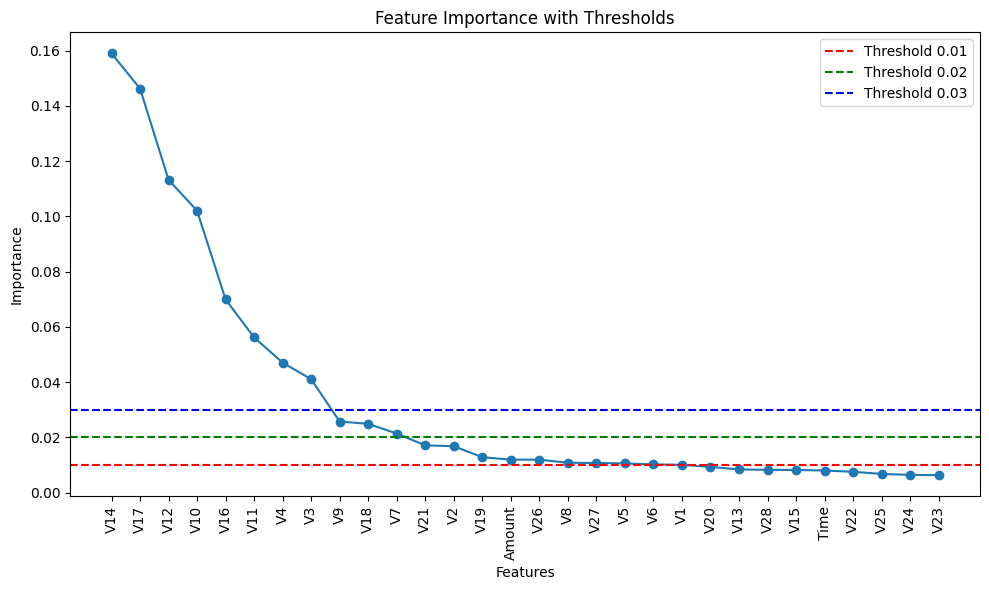

In [ ]:
# Step 3: Test different importance thresholds
thresholds = [0.01, 0.02, 0.03]
for thresh in thresholds:
    selected_features = feature_importance[feature_importance['Importance'] > thresh]['Feature'].tolist()
    print(f"Threshold {thresh}: {len(selected_features)} features - {selected_features}")

# Visualize importance distribution to assess threshold
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
plt.plot(range(len(feature_importance)), feature_importance['Importance'], marker='o')
plt.axhline(y=0.01, color='r', linestyle='--', label='Threshold 0.01')
plt.axhline(y=0.02, color='g', linestyle='--', label='Threshold 0.02')
plt.axhline(y=0.03, color='b', linestyle='--', label='Threshold 0.03')
plt.xticks(range(len(feature_importance)), feature_importance['Feature'], rotation=90)
plt.title('Feature Importance with Thresholds')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
final_threshold = 0.02
selected_features = feature_importance[feature_importance['Importance'] > final_threshold]['Feature'].tolist()
reduced_df = df[selected_features + ['Class']].copy()  # Exclude Amount, Amount_scaled, Time
print("Reduced dataset shape:", reduced_df.shape)
print("Selected features:", selected_features)

# Save reduced dataset
reduced_df.to_csv("reduced_creditcard.csv", index=False)

Reduced dataset shape: (284807, 12)
Selected features: ['V14', 'V17', 'V12', 'V10', 'V16', 'V11', 'V4', 'V3', 'V9', 'V18', 'V7']


In [ ]:
# Verify feature scales
print("Feature means:\n", reduced_df.drop('Class', axis=1).mean())
print("Feature stds:\n", reduced_df.drop('Class', axis=1).std())

Feature means:
 V14    1.207294e-15
V17   -3.772171e-16
V12   -1.247012e-15
V10    2.239053e-15
V16    1.437716e-15
V11    1.673327e-15
V4     2.074095e-15
V3    -1.379537e-15
V9    -2.406331e-15
V18    9.564149e-16
V7    -5.556467e-16
dtype: float64
Feature stds:
 V14    0.958596
V17    0.849337
V12    0.999201
V10    1.088850
V16    0.876253
V11    1.020713
V4     1.415869
V3     1.516255
V9     1.098632
V18    0.838176
V7     1.237094
dtype: float64


In [ ]:
# Load reduced dataset (unscaled)
reduced_df = pd.read_csv("reduced_creditcard.csv")

# Split data (60% normal, 20% normal + 50% fraud for CV, 20% normal + 50% fraud for test)
normal = reduced_df[reduced_df['Class'] == 0].copy()
fraud = reduced_df[reduced_df['Class'] == 1].copy()
train_fraud = normal.sample(frac=0.6, random_state=42).copy()
remaining_normal = normal.drop(train_fraud.index)
train_cv = pd.concat([remaining_normal.sample(frac=0.5, random_state=42), fraud.sample(frac=0.5, random_state=42)]).copy()
# train_test = pd.concat([remaining_normal.drop(train_cv[remaining_normal.index].index), fraud.drop(train_cv[fraud.index].index)]).copy()
# Fix: get only the row indices to drop
# train_test = pd.concat([
#     remaining_normal.drop(train_cv.index),
#     fraud.drop(train_cv.index)
# ]).copy()
train_test = pd.concat([
    remaining_normal.drop(train_cv.index.intersection(remaining_normal.index)),
    fraud.drop(train_cv.index.intersection(fraud.index))
]).copy()



# Separate features and labels
train_fraud_X = train_fraud.drop('Class', axis=1).copy()
train_cv_X = train_cv.drop('Class', axis=1).copy()
train_cv_y = train_cv['Class'].copy()
train_test_X = train_test.drop('Class', axis=1).copy()
train_test_y = train_test['Class'].copy()

# Gaussian Distribution
def multivariate_gaussian(X, mu, sigma):
    k = len(mu)
    sigma_inv = np.linalg.inv(sigma)
    det_sigma = np.linalg.det(sigma)
    const = 1 / ((2 * np.pi) ** (k / 2) * det_sigma ** 0.5)
    diff = X - mu
    exp_term = np.sum(np.dot(diff, sigma_inv) * diff, axis=1)
    return const * np.exp(-0.5 * exp_term)

mu = train_fraud_X.mean().values
sigma = np.cov(train_fraud_X.T)
p_cv = multivariate_gaussian(train_cv_X.values, mu, sigma)
p_test = multivariate_gaussian(train_test_X.values, mu, sigma)

# Test epsilon range
epsilons = np.logspace(-100, -20, num=50)
best_f1 = 0
best_epsilon = 0
for epsilon in epsilons:
    predictions = (p_cv < epsilon).astype(int)
    f1 = f1_score(train_cv_y, predictions)
    if f1 > best_f1:
        best_f1 = f1
        best_epsilon = epsilon
        best_precision = precision_score(train_cv_y, predictions)
        best_recall = recall_score(train_cv_y, predictions)

print(f"Best epsilon: {best_epsilon}")
print(f"Cross-validation - F1: {best_f1}, Precision: {best_precision}, Recall: {best_recall}")

# Test set
test_predictions = (p_test < best_epsilon).astype(int)
test_f1 = f1_score(train_test_y, test_predictions)
test_precision = precision_score(train_test_y, test_predictions)
test_recall = recall_score(train_test_y, test_predictions)
print(f"Test - F1: {test_f1}, Precision: {test_precision}, Recall: {test_recall}")

Best epsilon: 1.4563484775012623e-92
Cross-validation - F1: 0.8459869848156182, Precision: 0.9069767441860465, Recall: 0.7926829268292683
Test - F1: 0.8, Precision: 0.8708133971291866, Recall: 0.7398373983739838


In [ ]:
# Use same train_fraud_X, train_cv_X, train_test_X from Gaussian
iso_forest = IsolationForest(contamination=0.0017, random_state=42, n_jobs=-1)
iso_forest.fit(train_fraud_X)
cv_predictions = iso_forest.predict(train_cv_X)
cv_predictions = [1 if x == -1 else 0 for x in cv_predictions]  # -1 = anomaly, 1 = fraud
test_predictions = iso_forest.predict(train_test_X)
test_predictions = [1 if x == -1 else 0 for x in test_predictions]

# Evaluate
print("Isolation Forest Cross-validation:")
print(f"F1: {f1_score(train_cv_y, cv_predictions)}")
print(f"Precision: {precision_score(train_cv_y, cv_predictions)}")
print(f"Recall: {recall_score(train_cv_y, cv_predictions)}")
print("Isolation Forest Test:")
print(f"F1: {f1_score(train_test_y, test_predictions)}")
print(f"Precision: {precision_score(train_test_y, test_predictions)}")
print(f"Recall: {recall_score(train_test_y, test_predictions)}")

Isolation Forest Cross-validation:
F1: 0.6690909090909091
Precision: 0.6052631578947368
Recall: 0.7479674796747967
Isolation Forest Test:
F1: 0.6507352941176471
Precision: 0.5939597315436241
Recall: 0.7195121951219512


In [ ]:
# Step 1: Fit Isolation Forest (you can leave contamination at default since we won't use its threshold)
iso_forest = IsolationForest(n_estimators=100, random_state=42, n_jobs=-1)
iso_forest.fit(train_fraud_X)

# Step 2: Get raw anomaly scores for CV and Test
cv_scores = iso_forest.score_samples(train_cv_X)  # Higher = more normal
test_scores = iso_forest.score_samples(train_test_X)

# Step 3: Try different percentiles for threshold tuning
print("Isolation Forest Cross-validation (percentile tuning):")
best_f1 = 0
best_percentile = None

for p in [0.1, 0.5, 1, 2, 5]:  # Try more if needed
    threshold = np.percentile(cv_scores, p)
    cv_preds = (cv_scores < threshold).astype(int)

    f1 = f1_score(train_cv_y, cv_preds)
    precision = precision_score(train_cv_y, cv_preds)
    recall = recall_score(train_cv_y, cv_preds)

    print(f"Threshold = bottom {p}% → F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        best_percentile = p
        best_threshold = threshold

# Step 4: Apply best threshold to test set
print("\nIsolation Forest Test (using best threshold from CV):")
test_preds = (test_scores < best_threshold).astype(int)
f1 = f1_score(train_test_y, test_preds)
precision = precision_score(train_test_y, test_preds)
recall = recall_score(train_test_y, test_preds)

print(f"Best threshold = bottom {best_percentile}%")
print(f"F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")


Isolation Forest Cross-validation (percentile tuning):
Threshold = bottom 0.1% → F1: 0.3487, Precision: 0.9138, Recall: 0.2154
Threshold = bottom 0.5% → F1: 0.6729, Precision: 0.6259, Recall: 0.7276
Threshold = bottom 1% → F1: 0.4988, Precision: 0.3566, Recall: 0.8293
Threshold = bottom 2% → F1: 0.3067, Precision: 0.1864, Recall: 0.8659
Threshold = bottom 5% → F1: 0.1418, Precision: 0.0770, Recall: 0.8943

Isolation Forest Test (using best threshold from CV):
Best threshold = bottom 0.5%
F1: 0.6564, Precision: 0.6218, Recall: 0.6951


In [ ]:
# Grid for hyperparameter tuning
n_estimators_list = [100, 200]
max_samples_list = [256, 512, len(train_fraud_X)]  # or try 'auto'
max_features_list = [1.0, 0.8]
random_states = [42, 123]
percentiles = [0.1, 0.5, 1, 2, 5]

# Tracking best result
best_config = None
best_f1 = 0
results = []

print("Isolation Forest Full Tuning Grid Search:\n")

# Step through all combinations
for n_est, m_samp, m_feat, r_seed in product(n_estimators_list, max_samples_list, max_features_list, random_states):
    # Train Isolation Forest
    iso = IsolationForest(
        n_estimators=n_est,
        max_samples=m_samp,
        max_features=m_feat,
        random_state=r_seed,
        n_jobs=-1
    )
    iso.fit(train_fraud_X)

    # Score samples
    cv_scores = iso.score_samples(train_cv_X)
    test_scores = iso.score_samples(train_test_X)

    for p in percentiles:
        threshold = np.percentile(cv_scores, p)
        cv_preds = (cv_scores < threshold).astype(int)

        f1 = f1_score(train_cv_y, cv_preds)
        precision = precision_score(train_cv_y, cv_preds)
        recall = recall_score(train_cv_y, cv_preds)

        results.append({
            'n_estimators': n_est,
            'max_samples': m_samp,
            'max_features': m_feat,
            'random_state': r_seed,
            'percentile': p,
            'cv_f1': f1,
            'cv_precision': precision,
            'cv_recall': recall
        })

        if f1 > best_f1:
            best_f1 = f1
            best_config = {
                'n_estimators': n_est,
                'max_samples': m_samp,
                'max_features': m_feat,
                'random_state': r_seed,
                'percentile': p,
                'threshold': threshold
            }

        print(f"n={n_est}, ms={m_samp}, mf={m_feat}, seed={r_seed}, p={p}% → F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# Final test evaluation with best config
print("\nBest Configuration:")
print(best_config)

# Re-train with best config and evaluate on test set
iso_best = IsolationForest(
    n_estimators=best_config['n_estimators'],
    max_samples=best_config['max_samples'],
    max_features=best_config['max_features'],
    random_state=best_config['random_state'],
    n_jobs=-1
)
iso_best.fit(train_fraud_X)
test_scores = iso_best.score_samples(train_test_X)
test_preds = (test_scores < best_config['threshold']).astype(int)

f1 = f1_score(train_test_y, test_preds)
precision = precision_score(train_test_y, test_preds)
recall = recall_score(train_test_y, test_preds)

print("\nIsolation Forest Test Set Results:")
print(f"F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")


Isolation Forest Full Tuning Grid Search:

n=100, ms=256, mf=1.0, seed=42, p=0.1% → F1: 0.3487, Precision: 0.9138, Recall: 0.2154
n=100, ms=256, mf=1.0, seed=42, p=0.5% → F1: 0.6729, Precision: 0.6259, Recall: 0.7276
n=100, ms=256, mf=1.0, seed=42, p=1% → F1: 0.4988, Precision: 0.3566, Recall: 0.8293
n=100, ms=256, mf=1.0, seed=42, p=2% → F1: 0.3067, Precision: 0.1864, Recall: 0.8659
n=100, ms=256, mf=1.0, seed=42, p=5% → F1: 0.1418, Precision: 0.0770, Recall: 0.8943
n=100, ms=256, mf=1.0, seed=123, p=0.1% → F1: 0.3421, Precision: 0.8966, Recall: 0.2114
n=100, ms=256, mf=1.0, seed=123, p=0.5% → F1: 0.6504, Precision: 0.6049, Recall: 0.7033
n=100, ms=256, mf=1.0, seed=123, p=1% → F1: 0.4939, Precision: 0.3531, Recall: 0.8211
n=100, ms=256, mf=1.0, seed=123, p=2% → F1: 0.3067, Precision: 0.1864, Recall: 0.8659
n=100, ms=256, mf=1.0, seed=123, p=5% → F1: 0.1418, Precision: 0.0770, Recall: 0.8943
n=100, ms=256, mf=0.8, seed=42, p=0.1% → F1: 0.3355, Precision: 0.8793, Recall: 0.2073
n=100, 

In [ ]:
import numpy as np
from scipy.stats import norm
from sklearn.metrics import f1_score, precision_score, recall_score

# Step 1: Estimate μ and σ on normal training data (train_fraud_X)
mu = train_fraud_X.mean(axis=0).values
sigma = train_fraud_X.std(axis=0).values

# Step 2: Define function to calculate probability per feature (assuming independence)
def univariate_gaussian(X, mu, sigma):
    p = np.ones(X.shape[0])
    for i in range(len(mu)):
        p *= norm.pdf(X[:, i], mu[i], sigma[i])
    return p

# Step 3: Get probabilities for CV and test sets
p_cv = univariate_gaussian(train_cv_X.values, mu, sigma)
p_test = univariate_gaussian(train_test_X.values, mu, sigma)

# Step 4: Tune threshold (epsilon) on CV set
epsilons = np.logspace(-100, -20, 50)
best_f1, best_epsilon = 0, None

for epsilon in epsilons:
    preds = (p_cv < epsilon).astype(int)
    f1 = f1_score(train_cv_y, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_epsilon = epsilon
        best_precision = precision_score(train_cv_y, preds)
        best_recall = recall_score(train_cv_y, preds)

print("\nUnivariate Gaussian CV Results:")
print(f"Best epsilon: {best_epsilon:.2e}")
print(f"F1: {best_f1:.4f}, Precision: {best_precision:.4f}, Recall: {best_recall:.4f}")

# Step 5: Evaluate on test set
test_preds = (p_test < best_epsilon).astype(int)
f1 = f1_score(train_test_y, test_preds)
precision = precision_score(train_test_y, test_preds)
recall = recall_score(train_test_y, test_preds)

print("\nUnivariate Gaussian Test Results:")
print(f"F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")



Univariate Gaussian CV Results:
Best epsilon: 5.18e-55
F1: 0.6486, Precision: 0.7273, Recall: 0.5854

Univariate Gaussian Test Results:
F1: 0.6196, Precision: 0.7047, Recall: 0.5528


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.metrics import f1_score, precision_score, recall_score

# Step 1: Use robust statistics (median + IQR-based std)
mu = train_fraud_X.median().values
iqr = train_fraud_X.quantile(0.75) - train_fraud_X.quantile(0.25)
sigma = (iqr / 1.349).values  # IQR to std conversion (approx for normal dist)

# Step 2: Compute log-probabilities assuming feature independence
def log_univariate_gaussian(X, mu, sigma):
    log_p = np.zeros(X.shape[0])
    for i in range(len(mu)):
        log_p += norm.logpdf(X[:, i], mu[i], sigma[i])
    return log_p

# Step 3: Get log-probabilities for CV and test sets
p_cv = log_univariate_gaussian(train_cv_X.values, mu, sigma)
p_test = log_univariate_gaussian(train_test_X.values, mu, sigma)

# Step 4: Threshold tuning using CV set
epsilons = np.linspace(np.min(p_cv), np.max(p_cv), 100)
best_f1 = 0

for epsilon in epsilons:
    preds = (p_cv < epsilon).astype(int)
    f1 = f1_score(train_cv_y, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_epsilon = epsilon
        best_precision = precision_score(train_cv_y, preds)
        best_recall = recall_score(train_cv_y, preds)

# Step 5: Evaluate on test set using best threshold
test_preds = (p_test < best_epsilon).astype(int)
test_f1 = f1_score(train_test_y, test_preds)
test_precision = precision_score(train_test_y, test_preds)
test_recall = recall_score(train_test_y, test_preds)

# Output results
print("\n📊 Final Tuned Univariate Gaussian Results")

print(f"\n🔎 Cross-Validation Set:")
print(f"Best epsilon (log prob): {best_epsilon:.4f}")
print(f"F1:       {best_f1:.4f}")
print(f"Precision:{best_precision:.4f}")
print(f"Recall:   {best_recall:.4f}")

print(f"\n✅ Test Set:")
print(f"F1:       {test_f1:.4f}")
print(f"Precision:{test_precision:.4f}")
print(f"Recall:   {test_recall:.4f}")



📊 Final Tuned Univariate Gaussian Results

🔎 Cross-Validation Set:
Best epsilon (log prob): -193.3822
F1:       0.6264
Precision:0.6965
Recall:   0.5691

✅ Test Set:
F1:       0.5864
Precision:0.6649
Recall:   0.5244
